In [1]:
import argparse
import pickle
import re
from contextlib import ExitStack, nullcontext
from datetime import datetime, timedelta
from importlib import resources
from itertools import chain, tee
from os import environ, makedirs, path

 

import eccodes
import pdbufr
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.spatial import KDTree

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to import forecast storms file and load it in a dataframe
def create_storms_df():
    # Load cyclone dataframe with Mean sea level pressure value
    df_storms = pdbufr.read_bufr('track_data/tc_test_track_data.bufr',
        columns=("stormIdentifier", "longStormName", "ensembleMemberNumber", "year", "month", "day", "hour", "latitude", "longitude",
                 "pressureReducedToMeanSeaLevel"))
    # Load cyclone dataframe with Wind speed at 10m value
    df1 = pdbufr.read_bufr('track_data/tc_test_track_data.bufr',
        columns=("stormIdentifier", "longStormName", "ensembleMemberNumber", "latitude", "longitude",
                 "windSpeedAt10M"))
    # Load cyclone dataframe with timeperiod column
    df2 = pdbufr.read_bufr('track_data/tc_test_track_data.bufr',
        columns=("stormIdentifier", "longStormName", "ensembleMemberNumber", "latitude", "longitude",
                 "timePeriod"))
    # Load cyclone dataframe with radius with respect of wind speed
    df3 = pdbufr.read_bufr('track_data/tc_test_track_data.bufr',
        columns=("stormIdentifier", "longStormName", "ensembleMemberNumber", "latitude", "longitude",
                 "effectiveRadiusWithRespectToWindSpeedsAboveThreshold"))
    # Add the Wind speed at 10m column to the storms dataframe 
    df_storms["windSpeedAt10M"] = df1.windSpeedAt10M
    df_storms["timePeriod"] = df2.timePeriod
    df_storms["effectiveRadiusWithRespectToWindSpeedsAboveThreshold"] = df3.effectiveRadiusWithRespectToWindSpeedsAboveThreshold
    # Storms with number higher than 10 are not real storms (according to what Fernando said)
    drop_condition = df_storms.stormIdentifier < '11'
    df_storms = df_storms[drop_condition]
    return df_storms

# Function to reorganize storm dataframe as input for strike probability map calculation

def storm_df_reorganization(df):
    df.rename(columns={"ensembleMemberNumber":"number", "latitude":"lat", "longitude":"lon", "pressureReducedToMeanSeaLevel":"msl", "windSpeedAt10M":"wind"}, inplace=True)
    df.drop(columns=["stormIdentifier", "effectiveRadiusWithRespectToWindSpeedsAboveThreshold"])
    df['msl'] = df_storm['msl'] / 100
    dates = datetime(df.year[0], df.month[0], df.day[0], df.hour[0]) + timedelta(hours=1) * df.timePeriod
    df["date"] = dates.dt.strftime("%Y%m%d")
    df["step"] = dates.dt.strftime("%H").astype("int") * 100
    df.drop(columns=['year','month','day','hour'])
    df = df.reindex(['lat','lon','number','date','step','wind','msl'], axis=1)
    return df

In [3]:
df_storms = create_storms_df()
print(df_storms.stormIdentifier.unique())
df_storm = df_storms[df_storms.stormIdentifier == '07E']
df_storm.reset_index(drop=True, inplace=True)
df_storm_re = storm_df_reorganization(df_storm)
df_storm_re.head()

['07E' '08E' '09E' '09W']


,lat,lon,number,date,step,wind,msl
0,16.6,-128.9,1,20230817,600,18.5,999.0
1,16.3,-130.1,1,20230817,1200,18.0,1002.0
2,16.4,-131.3,1,20230817,1800,17.0,1002.0
3,16.3,-132.4,1,20230818,0,16.0,1005.0
4,16.4,-133.2,1,20230818,600,14.4,1003.0


In [4]:
# Functions
def previous_and_current(some_iterable):
    prevs, currs = tee(some_iterable, 2)
    prevs = chain([None], prevs)
    return zip(prevs, currs)


def ll_to_ecef(lat, lon, height=0.0, radius=6371229.0):
    lonr = np.radians(lon)
    latr = np.radians(lat)

    x = (radius + height) * np.cos(latr) * np.cos(lonr)
    y = (radius + height) * np.cos(latr) * np.sin(lonr)
    z = (radius + height) * np.sin(latr)
    return x, y, z


def distance_from_overlap(radius, overlap):
    assert 0.0 < radius
    assert 0.0 <= overlap < 1.0
    if overlap <= 0.0:
        return np.inf

    def overlap_unit_circles(d_over_r):
        assert 0.0 <= d_over_r
        if 2.0 <= d_over_r:
            return 0.0

        hd = d_over_r / 2.0
        ha_inter = np.arccos(hd) - hd * np.sqrt(1.0 - hd * hd)
        ha_union = np.pi - ha_inter
        return ha_inter / ha_union

    d = root_scalar(lambda d: overlap_unit_circles(d) - overlap, bracket=[0, 2], x0=1)
    return radius * d.root


def parse_range(rstr) -> set:
    s = set()
    for part in rstr.split(","):
        x = part.split("-")
        s.update(range(int(x[0]), int(x[-1]) + 1))
    return sorted(s)


def delta_hours(a: datetime, b: datetime) -> int:
    delta = a - b
    return delta // timedelta(hours=1)

In [5]:
# Read original input file
df = pd.read_csv(
    'pts-bundled/msl_05L_ELSA_2021070300.geo',
    sep=r"\s+",
    header=None,
    comment="#",
    names=["lat", "lon", "number", "date", "step", "wind", "msl"],
)
df["id"] = df.number
df.head()

,lat,lon,number,date,step,wind,msl,id
0,14.8,-65.3,1,20210703,0,41,1004,1
1,16.5,-67.8,1,20210703,600,42,1004,1
2,17.5,-70.6,1,20210703,1200,43,1004,1
3,19.1,-72.9,1,20210703,1800,28,1007,1
4,19.7,-74.6,1,20210704,0,29,1010,1


In [10]:
# Basetime mi sa è giorno del forecast (Date/time of the model run)
distance = 300.0e3
overlap = 0.7
dist_circle = distance_from_overlap(distance, overlap)
basetime = datetime.strptime(df.date[0].astype("str"), '%Y%m%d')

In [11]:
grib_template = 'pts-bundled/0.5_0.5.grib1'

f = open(grib_template, "rb")
h = eccodes.codes_grib_new_from_file(f)
assert h is not None
N = eccodes.codes_get(h, "numberOfDataPoints")
Ni = eccodes.codes_get(h, "Ni")
Nj = eccodes.codes_get(h, "Nj")

tree_path = eccodes.codes_get(h, "md5GridSection") + ".tree"

it = eccodes.codes_grib_iterator_new(h, 0)

P = np.empty([N, 3])
i = 0
while True:
    result = eccodes.codes_grib_iterator_next(it)
    if not result:
        break
    [lat, lon, value] = result

    assert i < N
    P[i, :] = ll_to_ecef(lat, lon)

    i += 1

eccodes.codes_grib_iterator_delete(it)
tree = KDTree(P)

In [12]:
# pre-process (apply filter_time and calculate/drop columns)
if df.empty:
    df[["lat", "lon", "number", "t", "wind", "msl"]] = None
    print("Warning:", df)
else:
    datestep = [
        datetime.strptime(k, "%Y%m%d%H%M")
        for k in (
            df.date.astype(str) + df.step.apply(lambda s: str(s).zfill(4))
        )
    ]
    if not basetime:
        basetime = min(datestep)
    df["t"] = [delta_hours(ds, basetime) for ds in datestep]
    # df = df[(args.filter_time[0] <= df.t) & (df.t <= args.filter_time[1])]

    df.drop(["date", "step"], axis=1, inplace=True)

df.head()

,lat,lon,number,wind,msl,id,t
0,14.8,-65.3,1,41,1004,1,0
1,16.5,-67.8,1,42,1004,1,6
2,17.5,-70.6,1,43,1004,1,12
3,19.1,-72.9,1,28,1007,1,18
4,19.7,-74.6,1,29,1010,1,24


In [13]:
# probability field (apply filter_number)
val = np.zeros(N)

# if args.filter_number:
#    numbers = args.filter_number
# else:
numbers = sorted(set(df.number.tolist()))
# if args.verbosity >= 1:
#     print(f"basetime: {basetime}")
#     print(f"len(numbers): {len(numbers)}, numbers: {numbers}")

for number in numbers:
    pts = set()

    tracks = df[df.number == number]
    for id in set(tracks.id.tolist()):
        # apply filter_wind
        # track = tracks[
        #     (tracks.id == id) & (args.filter_wind <= tracks.wind)
        # ].sort_values("t")
        track = tracks[tracks.id == id].sort_values("t")

        # special cases
        if track.shape[0] == 1:
            if args.verbosity >= 1:
                print(f"number={number} segments=0 len=1")
            p = ll_to_ecef(track.lat.iat[0], track.lon.iat[0])
            pts.update(tree.query_ball_point(p, r=args.distance))
            continue

        ti = np.array([])
        tend = None
        npoints = 1
        for a, b in previous_and_current(track.itertuples()):
            if a is not None:
                tend = b.t
                npoints += 1

                # approximate distance(a, b) with Cartesian distance
                ax, ay, az = ll_to_ecef(a.lat, a.lon)
                bx, by, bz = ll_to_ecef(b.lat, b.lon)
                dist_ab = np.linalg.norm(np.array([bx - ax, by - ay, bz - az]))

                num = max(1, int(np.ceil(dist_ab / dist_circle)))
                ti = np.append(
                    ti, np.linspace(a.t, b.t, num=num, endpoint=False)
                )
        if not tend:
            continue
        ti = np.append(ti, tend)

        assert 0 < npoints == track.shape[0]

        '''if args.verbosity >= 1:
            print(
                f"number={number} "
                f"segments={track.shape[0]-1} "
                f"len={len(ti)} "
                f"ss={round(float(len(ti)) / npoints, 1)}x"
            )'''

        lati = np.interp(ti, track.t, track.lat)
        loni = np.interp(ti, track.t, track.lon)

        # track points
        x, y, z = ll_to_ecef(lati, loni)
        for p in zip(x, y, z):
            pts.update(tree.query_ball_point(p, r=distance))

    for i in pts:
        assert i < N
        val[i] = val[i] + 1.0

if numbers:
    val = (val / len(numbers)) * 100.0  # %

# if args.verbosity >= 1 and len(numbers) > 1:
if len(numbers) > 1:

    def ranges(i):
        from itertools import groupby

        for _, b in groupby(enumerate(i), lambda pair: pair[1] - pair[0]):
            b = list(b)
            yield b[0][1], b[-1][1]

    mx = max(val)
    print(
        f"max={mx}, at {list(ranges(idx for idx, item in enumerate(val) if item == mx))}"
    )

assert 0 <= min(val) and max(val) <= 100.0

max=100.0, at [(98480, 98481), (99201, 99204), (99921, 99926), (100642, 100647), (101363, 101371), (102084, 102094), (102806, 102818), (103527, 103541), (104248, 104264), (104970, 104988), (105691, 105711), (106413, 106432), (107134, 107153), (107856, 107873), (108577, 108593), (109300, 109313), (110023, 110033), (110744, 110752), (111466, 111472), (112187, 112190)]


In [22]:
print(Ni, Nj)
prova = val.reshape((Nj,Ni))

720 361


In [23]:
np.unique(val)

array([  0.        ,   1.92307692,   3.84615385,   5.76923077,
         7.69230769,   9.61538462,  11.53846154,  13.46153846,
        15.38461538,  17.30769231,  19.23076923,  21.15384615,
        23.07692308,  25.        ,  26.92307692,  28.84615385,
        30.76923077,  32.69230769,  34.61538462,  36.53846154,
        38.46153846,  40.38461538,  42.30769231,  44.23076923,
        46.15384615,  48.07692308,  50.        ,  51.92307692,
        53.84615385,  55.76923077,  57.69230769,  59.61538462,
        61.53846154,  63.46153846,  65.38461538,  67.30769231,
        69.23076923,  71.15384615,  73.07692308,  75.        ,
        76.92307692,  78.84615385,  80.76923077,  82.69230769,
        84.61538462,  86.53846154,  88.46153846,  90.38461538,
        92.30769231,  94.23076923,  96.15384615,  98.07692308,
       100.        ])

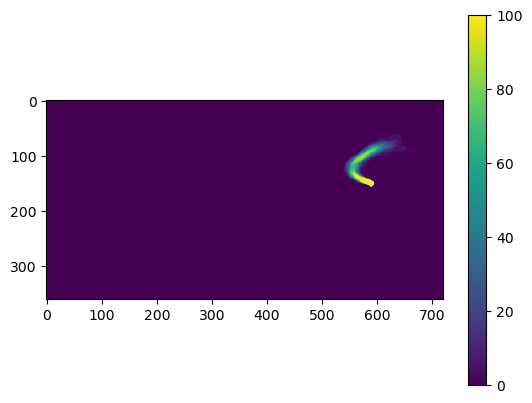

In [27]:
import matplotlib.pyplot as plt

plt.figure()
heatmap = plt.imshow(prova, cmap='viridis', interpolation='nearest')

plt.colorbar(heatmap)

# plt.xlim(500,700)
# plt.ylim(200,50)

plt.show()

In [30]:
prova

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])